<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/arithmetic_asian_basket_call_multivariate_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward networks

In this Jupyter notebook, we study the problem of reducing the standard error in Monte Carlo simulations when pricing path-dependent options through suitable changes of measure which are induced by feedforward networks.

We consider an arithmetic Asian basket call option in a multivariate Black-Scholes model.

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from tqdm.notebook import trange
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [2]:
########## ------------------------------
### Parameter initialization
T = 1
N = 32
delta_t = T/N
strike = 70.0
r = 0.05
N_assets = 10

In [3]:
X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets,1)),0)
mu = np.around(np.random.uniform(low=0.0, high=0.10, size=(N_assets, 1)),2)
sigma = np.around(np.random.uniform(low=-0.3, high=0.3, size=(N_assets,N_assets)), 2)
volvec = (norm(sigma, axis=0) ** 2).reshape((N_assets,1))
tilde_mu = mu - 0.5 * volvec

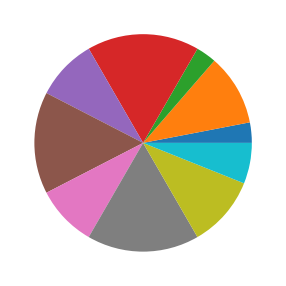

In [4]:
weights = np.around(mu / (norm(sigma, axis=0)).reshape((N_assets,1)),2)
weights = weights / np.sum(weights)
 
plt.figure(figsize=(9, 5)) 
plt.pie(weights.reshape((N_assets)))
plt.show()

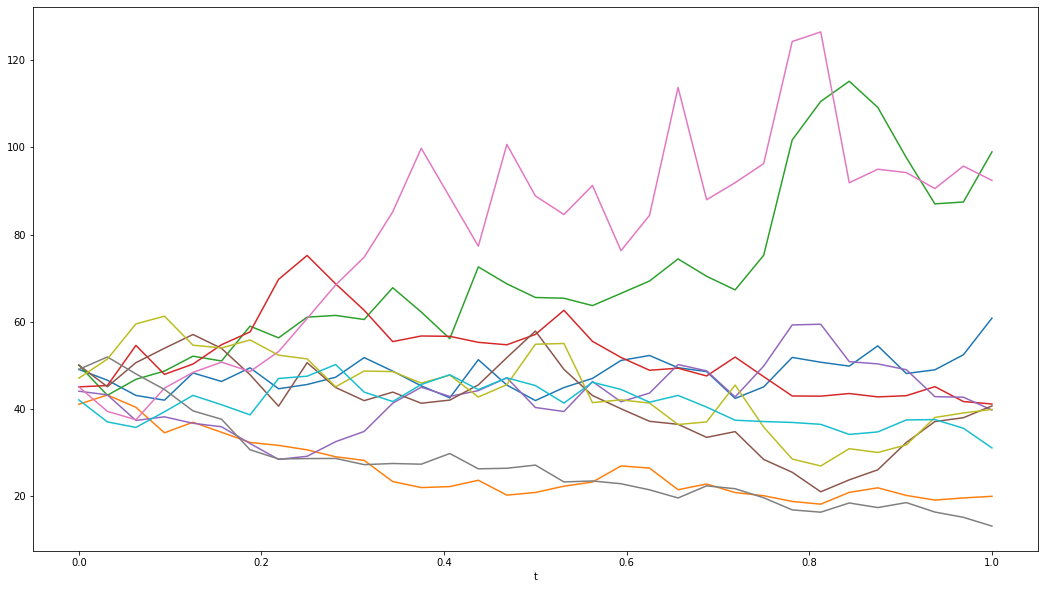

In [5]:
M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
M = np.cumsum(M, axis=1)
M = np.dot(np.transpose(sigma), M)
 
M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t
 
M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
M = np.cumsum(M, axis=1)
 
M = np.exp(M)
for i in range(N_assets):
    M[i,:] = M[i,:] * X_0[i]
    
t = np.linspace(0, T, N+1) 
plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M))
plt.xlabel("t")
plt.show()

In [6]:
N_sample = 5000
outcomes = []
 
start_time = time.time()
 
for i in trange(N_sample):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)
 
    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t
 
    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)
 
    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]
 
elapsed_time = time.time() - start_time
 
mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/5000 [00:00<?, ?it/s]

elapsed time:  00:00:01
Mean (MC):  1.2885
Standard error (MC):  0.603  ( 46.8 % )


In [7]:
N_sample = 20000
outcomes = []

start_time = time.time()

for i in trange(N_sample):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)

    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t

    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)

    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]

elapsed_time = time.time() - start_time

mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)

print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/20000 [00:00<?, ?it/s]

elapsed time:  00:00:06
Mean (MC):  0.738
Standard error (MC):  0.1662  ( 22.52 % )


In [8]:
N_sample = 100000
outcomes = []

start_time = time.time()

for i in trange(N_sample):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)

    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t

    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)

    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]

elapsed_time = time.time() - start_time

mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)

print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/100000 [00:00<?, ?it/s]

elapsed time:  00:01:06
Mean (MC):  0.9324
Standard error (MC):  0.082  ( 8.79 % )


In [9]:
########## ------------------------------
### Defining the feedforward network
 
R = 2*10**5
learnrate = 0.01
 
layers = []
 
layer = Dense(20, activation="tanh", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(1))
 
layers = layers + [layer]

In [10]:
########## ------------------------------
### Defining the training data
 
Ktrain = R
xtrain = ([0*np.ones((Ktrain,1))] + # t_0
          [delta_t*np.ones((Ktrain,N_assets))] + # time increment
          [0*np.ones((Ktrain,N_assets))] + # M_0
          [np.tile(X_0.reshape((N_assets)), (Ktrain, 1))] + # X_0
          [np.tile(weights.reshape((N_assets))/T, (Ktrain, 1))] + # wght
          [0*np.ones((Ktrain,N_assets))] + # initial value of the payoff
          [0*np.ones((Ktrain,N_assets))] + # initial value of the first part of the stoch exp
          [0*np.ones((Ktrain,N_assets))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(Ktrain,N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((Ktrain, 1))

In [11]:
### Training loop
 
t_0 = Input(shape=(1, ))
d_t = Input(shape=(N_assets, ))
 
M_0 = Input(shape=(N_assets, ))
X_start = Input(shape=(N_assets, ))
 
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(N_assets, ))
 
inputs = [t_0]+[d_t]+[M_0]+[X_start]+[wght]+[c_0]+[c_1]+[c_2]
 
t_current = t_0
M_current = M_0
X_current = X_start
 
for j in range(N):
    
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    incr_M = Input(shape=(N_assets, ))
    inputs = inputs + [incr_M]
    
    M_current = Add()([M_current, incr_M])
    helper_0 = tf.transpose(K.dot(K.constant(np.transpose(sigma)), tf.transpose(M_current)))
    helper_1 = Lambda(lambda x: tilde_mu.reshape((N_assets)) * x)(t_current)
    helper_2 = Add()([helper_1, helper_0])
    helper_3 = Lambda(lambda x: K.exp(x))(helper_2)
    helper_4 = Multiply()([helper_3, d_t])
    helper_5 = Multiply()([X_start, helper_4])
    helper_6 = Multiply()([wght, helper_5])
    c_0 = Add()([c_0, helper_6])
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy])
    helper_e3 = Multiply()([helper_e2, d_t])
    c_2 = Add()([c_2, helper_e3])
    
    t_current = Lambda(lambda x: x + delta_t)(t_current)
    
helper_e4 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_e5 = Lambda(lambda x: 0.25 * K.sum(x, axis=1))(c_2)
 
helper_e6 = Add()([helper_e4, helper_e5])
helper_e7 = Lambda(lambda x: K.exp(x))(helper_e6)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_e7])
 
outputs = [c_0]

In [12]:
def custom_loss(y_true,y_pred):
    z = K.mean(K.square(y_pred))
    return z
 
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam,loss=custom_loss)

In [ ]:
# model.summary()
# K.set_value(model.optimizer.learning_rate, 0.0001)

In [13]:
model.fit(x=xtrain, y=ytrain, verbose=1, epochs=10, batch_size=100, shuffle = True)

Epoch 1/10
2000/2000 [==============================] - 44s 19ms/step - loss: 0.0030
Epoch 2/10
2000/2000 [==============================] - 38s 19ms/step - loss: 8.7563e-04
Epoch 3/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.0298
Epoch 4/10
2000/2000 [==============================] - 38s 19ms/step - loss: 0.0012
Epoch 5/10
2000/2000 [==============================] - 37s 19ms/step - loss: 8.6527e-04
Epoch 6/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.0100
Epoch 7/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.0010
Epoch 8/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.0029
Epoch 9/10
2000/2000 [==============================] - 37s 19ms/step - loss: 9.3740e-04
Epoch 10/10
2000/2000 [==============================] - 37s 18ms/step - loss: 0.0700


In [ ]:
# model.summary()

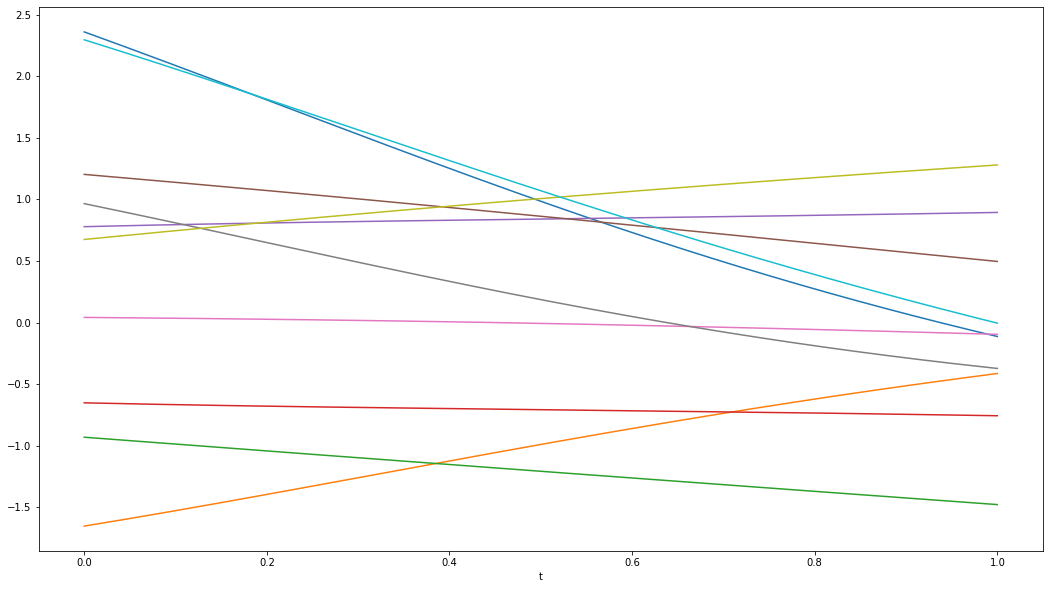

In [14]:
N = 252
delta_t = T/N
 
model_test = keras.Sequential()
model_test.add(Dense(20, activation="tanh", name="layer1", input_shape=(1, )))
model_test.add(Dense(N_assets, activation="linear", name="layer2"))
 
model_test.build()
 
model_test.layers[0].set_weights(model.layers[27].get_weights())
model_test.layers[1].set_weights(model.layers[38].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

In [ ]:
M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)

M_MC = np.cumsum(M_random, axis=1)
M_MC = np.dot(np.transpose(sigma), M_MC)

M_MC = np.diff(M_MC, axis=1)
M_MC = M_MC + tilde_mu * delta_t

M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
M_MC = np.cumsum(M_MC, axis=1)

M_MC = np.exp(M_MC)
for j in range(N_assets):
    M_MC[j,:] = M_MC[j,:] * X_0[j]
        
###

M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
M_0 = np.cumsum(M_0, axis=1)
M = np.dot(np.transpose(sigma), M_0)

M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t

M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
M = np.cumsum(M, axis=1)

M = np.exp(M)
for j in range(N_assets):
    M[j,:] = M[j,:] * X_0[j]

plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M), color = "blue", label="with drift adjustment")
plt.plot(t, np.transpose(M_MC), color = "red", label="without drift adjustment")
plt.xlabel("t")
# plt.legend(loc="upper left")
plt.show()

In [15]:
N_reps = 100
N_sample = 5000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
    outcomes_MC = []
    outcomes_IS = []
    
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

elapsed time:  00:00:43
elapsed time:  00:01:27
elapsed time:  00:02:11
elapsed time:  00:02:55
elapsed time:  00:03:38
elapsed time:  00:04:22
elapsed time:  00:05:05
elapsed time:  00:05:48
elapsed time:  00:06:32
elapsed time:  00:07:15
total elapsed time:  00:07:15


In [16]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  0.5671
Mean (IS):  0.5562
Standard error (MC):  0.2713  ( 47.85 % )
Standard error (IS):  0.0513  ( 9.22 % )
Variance ratio:  54.0


mean MC estimate:   0.5671
mean IS estimate:  0.5562


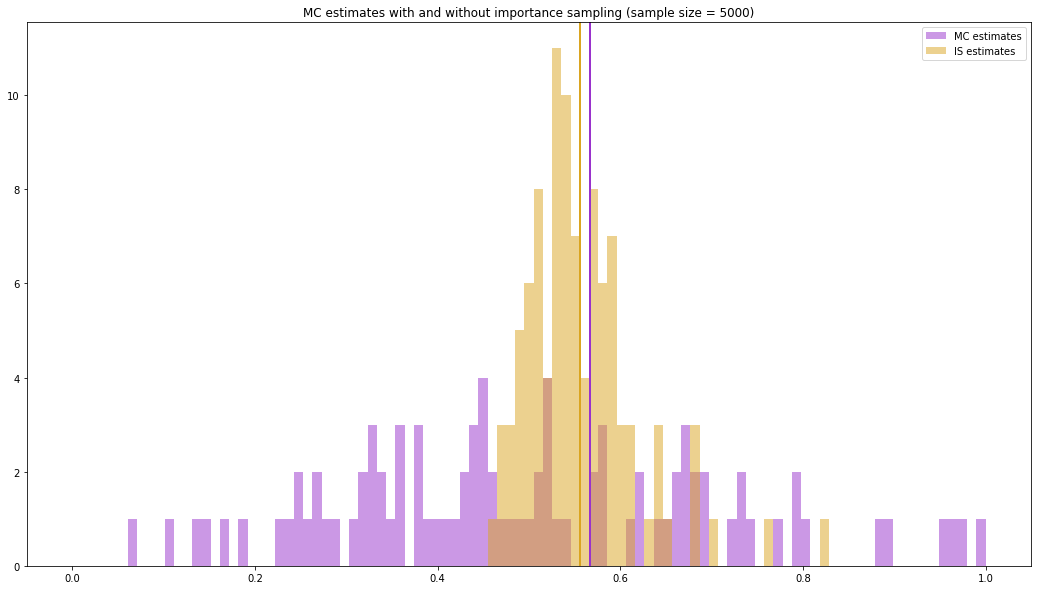

In [17]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(0.00, 1.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.2713
mean IS estimate standard error:  0.0513


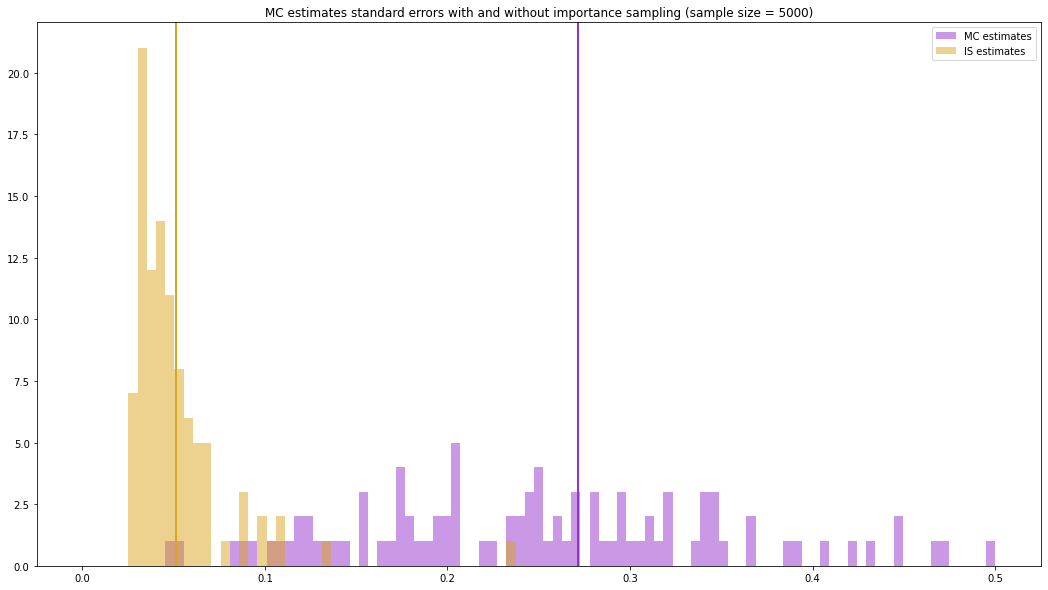

In [18]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 0.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

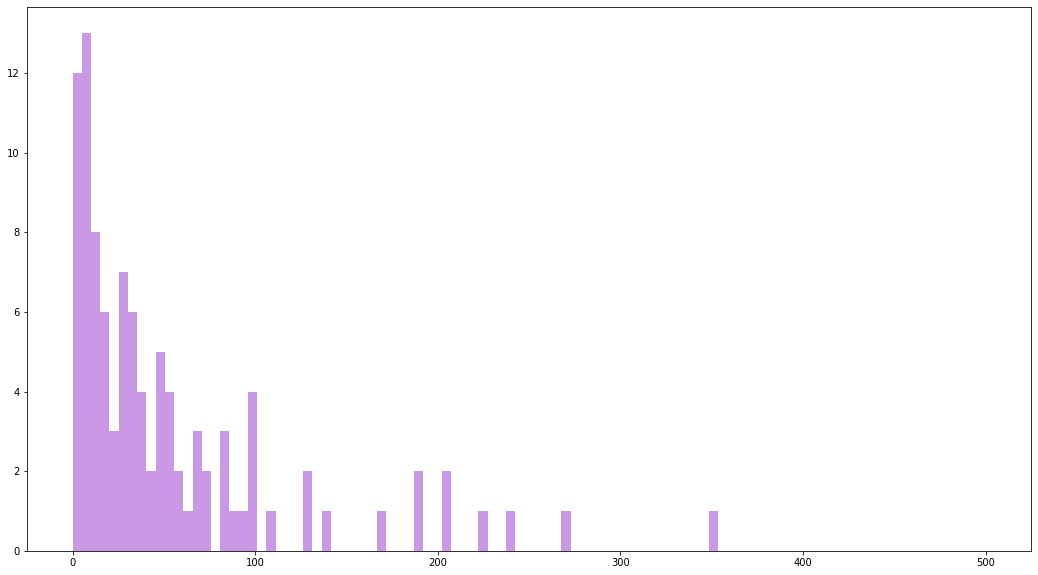

In [21]:
bins = np.linspace(0.00, 500.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [20]:
import pandas as pd
 
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(10))

     mean MC   mean IS  stderr MC  stderr IS    varratio
1   0.970441  0.554249   0.725026   0.061013  141.209523
25  0.992624  0.484402   0.432264   0.033021  171.359965
90  1.285666  0.511804   0.446478   0.032449  189.326389
66  0.961214  0.488304   0.406381   0.029433  190.638410
3   1.000096  0.509272   0.422533   0.029542  204.565434
53  1.000560  0.543265   0.448814   0.031299  205.618565
75  1.061655  0.514561   0.615654   0.041080  224.598259
81  1.061471  0.534644   0.494992   0.032008  239.154763
37  1.595552  0.488309   0.545285   0.033175  270.159133
56  1.656672  0.579672   0.757297   0.040320  352.772363


In [ ]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

In [ ]:
N_reps = 100
N_sample = 20000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

In [ ]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(5.00, 15.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 20000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 20000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
bins = np.linspace(0.00, 50.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [ ]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(50))

In [ ]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

In [ ]:
stderr_IS[25]

In [ ]:
N_reps = 25
N_sample = 100000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Variance ratio: ", np.around(np.mean(varratio)))

In [ ]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(5.00, 15.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 100000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 100000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
bins = np.linspace(0.00, 50.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.show()

In [ ]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(25))

In [ ]:
print(np.around(stderr_MC[0] / means_MC[0] * 100, 6))
print(np.around(stderr_IS[0] / means_IS[0] * 100, 6))

In [ ]:
stderr_IS[0]

In [ ]:
N_reps = 1
N_sample = 1000000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
# for k in progressbar(range(N_reps), "Computing: ", 60):
    outcomes_MC = []
    outcomes_IS = []
    
    # for i in trange(N_sample):
    # for i in progressbar(range(N_sample), "Computing: ", 60):
    for i in trange(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
    if (k+1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))